In [1]:
from sklearn.decomposition import PCA
import numpy as np
from jupyterthemes import jtplot
jtplot.style()

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline

np.random.seed(42)

- Need for dimensionality reductions
- Intuition
- Dive into maths
- Applications
- Other Dim reductions algorithms

# Code Bytes - PCA
## Introduction
In today's session, we'll explore Principal Component Analysis, a popular algorithm for *reducing dimensionality* of a dataset. But first, here's a fun fact:

- If you randomly pick two points in a unit square, the average distance between them is roughly 0.52
- If you randomly pick two points in a unit unit 3D cube, the average distance is roughly 0.66

In [2]:
a, b = [np.random.random(2) for _ in range(2)]
x, y, z = [np.random.random(2) for _ in range(3)]

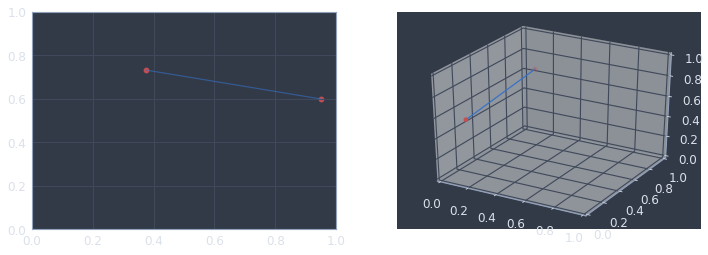

In [3]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.scatter(a, b, marker='o', c='r')
ax1.plot(a,b, linestyle='-', c='b', alpha=0.6)
ax1.set_xlim(0, 1)
ax1.set_ylim(0,1)

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x, y, z, c='r')
ax2.plot(x, y, z, linestyle='-', c='b')
ax2.set_xlim(0, 1)
ax2.set_ylim(0,1)
ax2.set_zlim(0,1)

plt.show()

In a 1,000,000-dimensional hypercube the average distance is about 408.25! [[1]](https://martin-thoma.com/curse-of-dimensionality/)

What I'm trying to say is; the more features a dataset has, the more sparse it is. That is, when you train a ML model with a large number of features, any new instances (i.e. unseen data points) are very unlikely to be close to any instance your model has already seen. Your model becomes prone to overfitting and so predictions become less reliable.

**Reducing the dimensionality** of our dataset means taking it from a high dimensional space and transforming it into a smaller space.

$$ \mathbb{R}^n \rightarrow \mathbb{R}^k \quad\quad n, k \in \mathbb{R}, k<n $$

## Intuition behind PCA

Before diving in how the algorithm works, let's grow our intuition for it. Suppose you're working with some dataset which has two features $x_1, x_2$ and you plot them

Plots below taken from [[2]](https://github.com/ageron/handson-ml2/blob/master/08_dimensionality_reduction.ipynb)

In [4]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

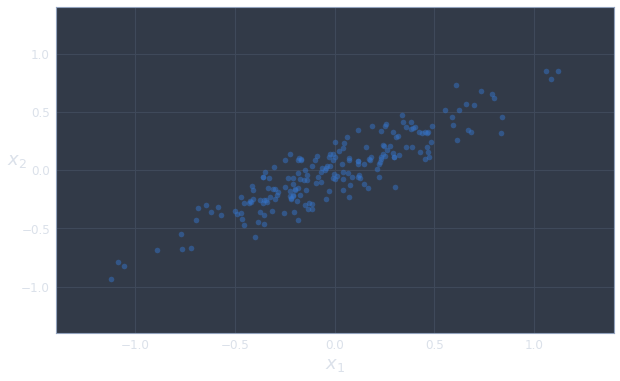

In [5]:
plt.figure(figsize=(10,6))
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

A normal person might say *cool*. 

A mathematician might ask: *Can you reduce this 2-D space into 1 dimension?*

To which you reply: *But why?*

You turn around and the mathematician is gone, but you can't get the question out of your head and start to ponder about it. 

*If I'm going to represent this in 1 dimension, I will be squishing the points down to a line*

And you draw a few possible lines

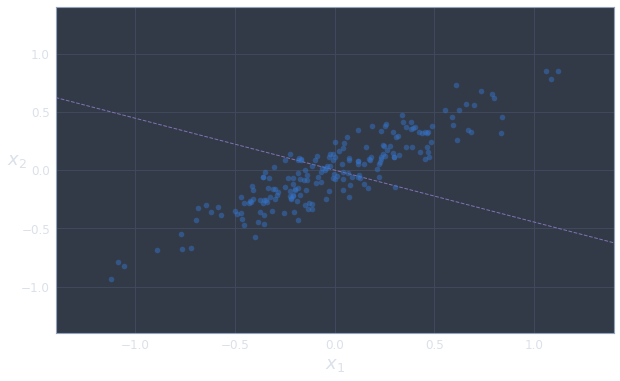

In [6]:
u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

plt.figure(figsize=(10,6))
# plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "m--", linewidth=1)
# plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "c:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

So how do you decide which of these lines is the best one to use?

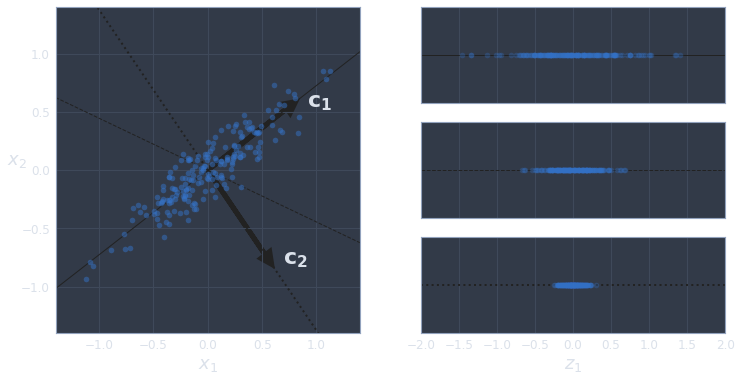

In [7]:
X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(12,6))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

You decide to project the points on these lines and see how they look in 1 dimension. Doing so, you notice the plot on the top left shows the points more dispersed than the other plots, i.e. it is easier for you to distinguish between points because this projection retained the **variance** better than the other projections

Here's another example projecting 3 dimensions to 2

In [8]:
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

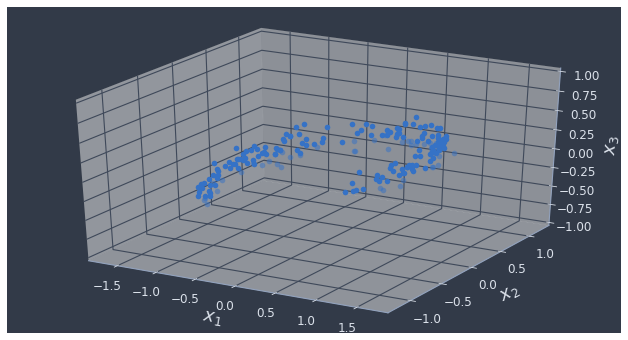

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(111, projection='3d')
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

X3D_inv_using_svd = X2D.dot(Vt[:2, :])

X3D_above = X[X[:, 2] > X3D_inv_using_svd[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv_using_svd[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

In 3D instead of drawing lines, we'll be drawing 2D planes and again, we want to pick the one that best represents our data without losing too much information

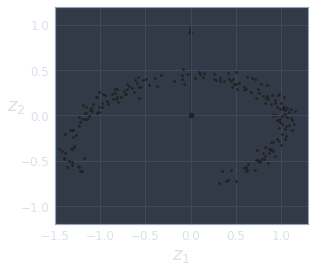

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
plt.show()

To recap:
- PCA is a way to reduce a dataset from $n$ dimensions to a smaller number of dimensions $k$
- You can think of this as *compressing* the data
- We want to reduce the amount of information lost during compression

What is this information we want to minimize? How do we go about doing it? How many dimensions should you pick?

## Principal Components

The goal of PCA is to find the axes that accounts for the largest amount of variance in the data. For an $n$ dimensional dataset, we can find $n$ such axes that do so, but since our goal is to reduce the number of dimensions, we typically don't want to use all $n$ axes.


Each axis that accounts for the largest amount of variance in some direction is called a **principal component**. But what does it mean for an axis to account for the largest amount of variance?

Suppose we have a dataset with 3 columns, where the third one is the average of the first two plus some random noise

In [11]:
X = np.random.rand(5, 2)
X = np.c_[X, ((X[:, 0] + X[:, 1])/2 + np.random.normal()).reshape(-1, 1)]
X

array([[0.9974543 , 0.92041602, 1.98420254],
       [0.5392012 , 0.88839617, 1.73906606],
       [0.16186458, 0.62998007, 1.4211897 ],
       [0.8144895 , 0.26257289, 1.56379857],
       [0.56009347, 0.51800739, 1.56431781]])

We can compute the variance of each column

In [12]:
np.var(X, axis=0)

array([0.08003171, 0.05953851, 0.03732969])

And the total variance, defined as the sum of each individual variance

In [13]:
sum(np.var(X, axis=0))

0.17689990852311355

Now we can calculate how much each feature contribute to the total variance, i.e. how much variance each feature explains

In [14]:
for idx, val in enumerate(np.var(X, axis=0)/sum(np.var(X, axis=0))):
    print(f'Feature {idx+1} contributes to {100*val:.2f}% of the total variance')

Feature 1 contributes to 45.24% of the total variance
Feature 2 contributes to 33.66% of the total variance
Feature 3 contributes to 21.10% of the total variance


We can also talk about how much variance a subset of features explains

When we perform PCA, we find a new set of axis (components) and re-express the data in term of these variables. 

In [15]:
X_pca = PCA(n_components=3).fit_transform(X)
X_pca

array([[ 5.72220064e-01, -6.55359052e-02,  3.48121527e-17],
       [ 8.72248109e-02, -2.54989522e-01,  5.40133887e-17],
       [-4.67313077e-01, -2.03076913e-01,  1.59619817e-17],
       [-5.27982211e-02,  4.36784047e-01,  2.12827934e-17],
       [-1.39333577e-01,  8.68182928e-02,  1.15181019e-16]])

Note that these new principal components have the same variance as our previous data (limited floating point precision)

In [16]:
sum(np.var(X_pca, axis=0))

0.1768999085231135

And again we can check how much each of these components contributes to the total variance

In [17]:
for idx, val in enumerate(np.var(X_pca, axis=0)/sum(np.var(X_pca, axis=0))):
    print(f'Feature {idx+1} contributes to {100*val:.2f}% of the total variance')

Feature 1 contributes to 65.08% of the total variance
Feature 2 contributes to 34.92% of the total variance
Feature 3 contributes to 0.00% of the total variance


Note that with these new principal components, the third feature almost doesn't give any information, hence we can just use the first two principal components to represent our data!

The section above was adapted from [[3]](https://ro-che.info/articles/2017-12-11-pca-explained-variance). See link for further mathematical justifications

## Singular Value Decomposition

Just like numbers can be decomposed into their 'atomic' parts (prime numbers), matrices can be decomposed as the product of other matrices. There are many methods for doing this and Singular Value Decomposition is one of them.

Given $X \in M_{m\times n}(\mathbb{R})$, SVD transforms $\mathbf{X}$ into the product $\mathbf{X} = \mathbf{U\Sigma V}^{\intercal}$ where:
- $\mathbf{U} \in M_{m\times m}(\mathbb{R})$
- $\mathbf{\Sigma} \in M_{m\times n}(\mathbb{R})$ 
- $\mathbf{V}^{\intercal} \in M_{n\times n}(\mathbb{R})$

$\mathbf{U}$ and $\mathbf{V}^{\intercal}$ are orthogonal matrices and $\mathbf{\Sigma}$ is a diagonal matrix. Let's look at an example to understand what this means.

Start by generate 100 random data points for 3 features and center it (i.e. for each column we subtract it's mean)

In [68]:
X = np.random.rand(100, 3)
X_centered = X - X.mean(axis=0)
X_centered[:5]

array([[-0.00458382, -0.11829371, -0.43742016],
       [-0.27378297,  0.45493275,  0.15219914],
       [-0.0906227 , -0.18497327, -0.44191497],
       [-0.31437811,  0.38221976, -0.1128446 ],
       [ 0.11042268, -0.27803244,  0.27405539]])

We can use ```np.linalg.svd``` to calculate the SVD of a matrix. Computing the decomposition is a taks in the realm of numerical analysis and won't be discussed here.

In [69]:
U, s, Vt = np.linalg.svd(X_centered)

For a matrix $\mathbf{A} = [\mathbf{a_1}\quad\mathbf{a_2}\quad\cdots\quad\mathbf{a_n}]$ to be orthogonal means that the column vectors $\mathbf{a_i}$ of $\mathbf{A}$ are orthogonal from each other (i.e. their dot product is zero) and the vectors have unit length. We know $\mathbf{U}$ and $\mathbf{V}^{\intercal}$ are orthogonal so let's verify that

In [75]:
# Get each colum of Vt as a vector by transposing it
v1, v2, v3 = Vt.T

In [76]:
# Calculate the dot product
np.dot(v2, v3)

3.3306690738754696e-16

We don't get exactly 0 due to the maximum precision in floating point arithmetic when dealing with irrational numbers

In [78]:
# Check the norm of each colum vector
np.linalg.norm(Vt, axis=0)

array([1., 1., 1.])

Sigma being a diagonal matrix means all of it's values are zeroes, except the ones on the main diagonal

In [79]:
np.diag(s)

array([[2.99153494, 0.        , 0.        ],
       [0.        , 2.95245241, 0.        ],
       [0.        , 0.        , 2.87080199]])

The reason we perform this decompositions is that the column vectors of $\mathbf{V}^{\intercal}$ are the principal components we're looking for! Let's pick the first 2 principal components and store them in a matrix $\mathbf{W} = [\mathbf{v}_1 \quad \mathbf{v}_2]$

We can now project the original matrix onto the 2D plane by calculating the dot product

$$ \mathbf{X}_{\text{proj}} = \mathbf{X}\cdot\mathbf{W} $$

In [80]:
W = Vt[:, :2]
X_proj = X_centered.dot(W)

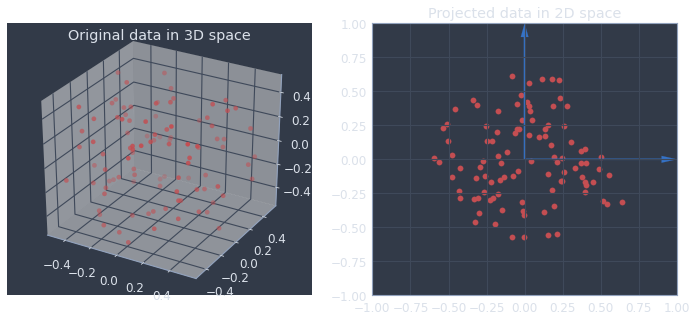

In [110]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_centered[:, 0], X_centered[:, 1], X_centered[:, 2], marker='o', c='r')
ax1.set_title('Original data in 3D space')

ax2 = fig.add_subplot(122)
ax2.scatter(X_proj[:, 0], X_proj[:, 1], marker='o', c='r')
ax2.arrow(0, 0, 0, 1, width=0.01, head_width=0.05, length_includes_head=True, 
          head_length=0.1, fc='b', ec='b')
ax2.arrow(0, 0, 1, 0, width=0.01, head_width=0.05, length_includes_head=True, 
          head_length=0.1, fc='b', ec='b')
ax2.set_xlim(-1,1)
ax2.set_ylim(-1,1)
ax2.set_title('Projected data in 2D space')
plt.show()

Note: Centering the data is important as it prevents features with large means from dominating the PCA. [[4](https://stackoverflow.com/questions/42024705/should-i-perform-data-centering-before-apply-svd)], [[5](https://stats.stackexchange.com/questions/189822/how-does-centering-make-a-difference-in-pca-for-svd-and-eigen-decomposition)]

## PCA in practice

Possible example to use [iris](https://scikit-learn.org/stable/modules/decomposition.html#pca), Mnist 